**Project Introduction: Predicting Sepsis Risk in ICU Patients**

In this machine learning project, our goal is to develop a predictive model that can help healthcare professionals identify whether a patient in the Intensive Care Unit (ICU) is at risk of developing sepsis. Sepsis is a critical condition, and early detection is crucial for timely intervention and improved patient outcomes.

**Dataset Description:**

- **ID:** Unique patient identifier.
- **PRG (Plasma Glucose):** Plasma glucose levels.
- **PL (Blood Work Result-1):** Blood work result 1 (mu U/ml).
- **PR (Blood Pressure):** Blood pressure in mm Hg.
- **SK (Blood Work Result-2):** Blood work result 2 (mm).
- **TS (Blood Work Result-3):** Blood work result 3 (mu U/ml).
- **M11 (Body Mass Index):** Body mass index (weight in kg / (height in m)^2).
- **BD2 (Blood Work Result-4):** Blood work result 4 (mu U/ml).
- **Age:** Patient's age in years.
- **Insurance:** Indicates if the patient holds a valid insurance card.
- **Sepsis (Target):** Binary target variable - Positive if the patient will develop sepsis in the ICU, Negative otherwise.

By utilizing these patient attributes, we aim to create a model that can assist healthcare providers in making informed decisions and potentially saving lives through early sepsis risk detection.

In [1]:
# !pip install lightgbm
# !pip install catboost
# !pip install python-dotenv
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 
import lightgbm as lgb
import catboost
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")


In [3]:
df_train = pd.read_csv('Asset\Paitients_Files_Train.csv')

In [4]:
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [5]:
df_train.shape

(599, 11)

In [6]:
df_train.info

<bound method DataFrame.info of             ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0    ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1    ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2    ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3    ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4    ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive
..         ...  ...  ...  ..  ..  ...   ...    ...  ...        ...       ...
594  ICU200604    6  123  72  45  230  33.6  0.733   34          0  Negative
595  ICU200605    0  188  82  14  185  32.0  0.682   22          1  Positive
596  ICU200606    0   67  76   0    0  45.3  0.194   46          1  Negative
597  ICU200607    1   89  24  19   25  27.8  0.559   21          0  Negative
598  ICU200608    1  173  74   0    0  36.8  0.088   38          1  Positive

[599 rows x 11 columns]>

In [7]:
df_train.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [8]:
# Summary statistics for numerical columns
numerical_summary = df_train.describe()
print("\nNumerical Summary:")
print(numerical_summary)


Numerical Summary:
              PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  123.500000   36.550000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2         Age   Insurance  
count  599.000000  599.000000  599.000000  
mean     0.481187   33.290484    0.686144  
std      0.337552   11.828446    0.464447  
min      0.078000   21.000000    0.000000  
25%      0.248000   24.000000 

1. **PRG (Plasma Glucose):**
   - The mean plasma glucose level is approximately 3.82.
   - The standard deviation is relatively high, indicating variability in glucose levels.
   - The minimum value is 0, which may need further investigation.
   - The range of values is from 0 to 17.

2. **PL (Blood Work Result-1):**
   - The mean value for this attribute is about 120.15.
   - The standard deviation suggests some variability in the results.
   - The minimum value is 0, which might be problematic.
   - The range of values is from 0 to 198.

3. **PR (Blood Pressure):**
   - The mean blood pressure is around 68.73 mm Hg.
   - The standard deviation indicates variability in blood pressure readings.
   - The minimum value is 0, which might be problematic.
   - The range of values is from 0 to 122.

4. **SK (Blood Work Result-2):**
   - The mean value for this attribute is approximately 20.56 mm.
   - The standard deviation suggests variability.
   - The minimum value is 0, which could be a concern.
   - The range of values is from 0 to 99.

5. **TS (Blood Work Result-3):**
   - The mean value for this attribute is roughly 79.46 mu U/ml.
   - There is a high standard deviation, indicating a wide spread of values.
   - The minimum value is 0, which might require investigation.
   - The range of values is from 0 to 846.

6. **M11 (Body Mass Index):**
   - The mean BMI is approximately 31.92.
   - The standard deviation is moderate.
   - The minimum value is 0, which could indicate missing or incorrect data.
   - The range of values is from 0 to 67.1.

7. **BD2 (Blood Work Result-4):**
   - The mean value for this attribute is about 0.48 mu U/ml.
   - The standard deviation suggests some variability.
   - The minimum value is 0.078, indicating a narrower range.
   - The range of values is from 0.078 to 2.42.

8. **Insurance:**
   - This binary variable indicates insurance status.
   - The mean value is approximately 0.69, suggesting that a majority of patients have insurance (1) in the dataset.

In [9]:
df_test = pd.read_csv('Asset\Paitients_Files_Test.csv')

In [10]:
df_test

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [11]:
df_test.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64

## EDA

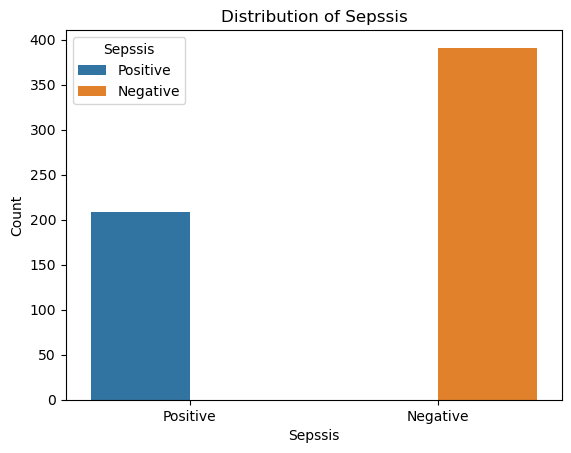

In [12]:
# Class distribution for the 'Sepssis' target variable
sns.countplot(data=df_train, x='Sepssis', hue='Sepssis')
plt.title('Distribution of Sepssis')
plt.xlabel('Sepssis')
plt.ylabel('Count')
plt.show()

It will help you understand the balance or imbalance in your dataset, which is crucial for building a predictive model. An imbalanced dataset may require special handling, such as resampling techniques

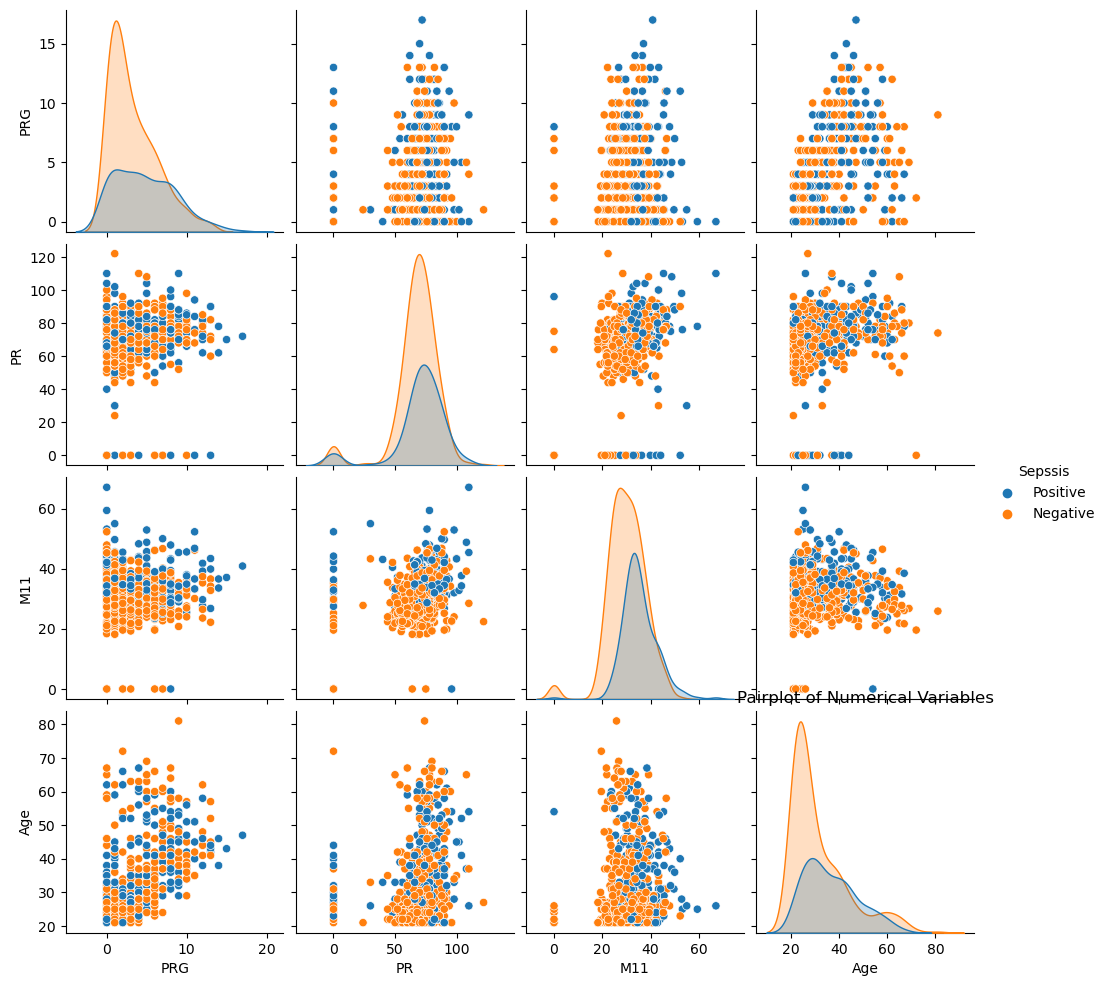

In [13]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df_train, hue='Sepssis', vars=['PRG', 'PR', 'M11', 'Age'])
plt.title('Pairplot of Numerical Variables')
plt.show()

It will allow you to visually explore relationships and patterns between these numerical features and how they relate to the target variable.
You can identify if there are any clear separations or clusters of data points for the different 'Sepsis' classes.

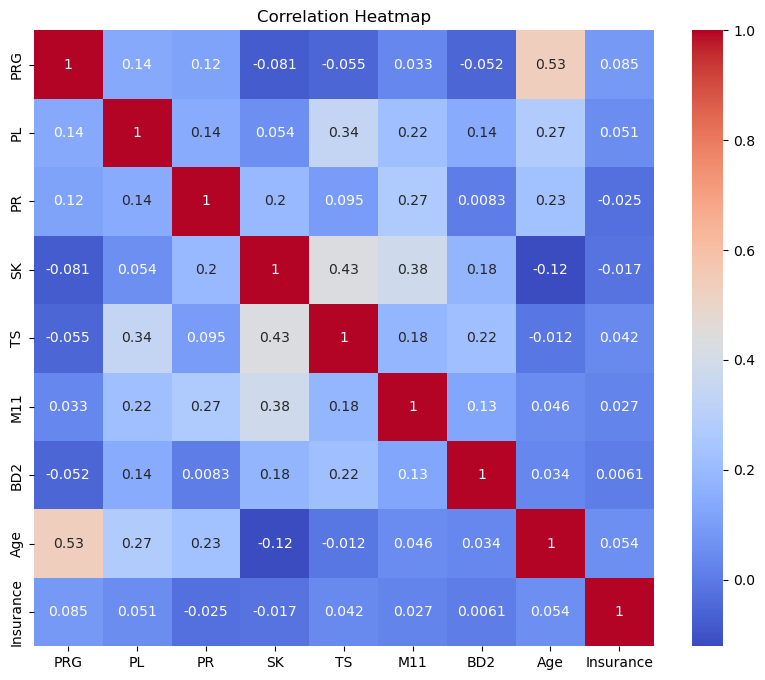

In [14]:
# Correlation heatmap for numerical variables
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

This heatmap will help you identify potential multicollinearity (high correlation between independent variables), which can impact the performance of certain machine learning models.
Variables with strong positive or negative correlations with 'Sepsis' may be important predictors.

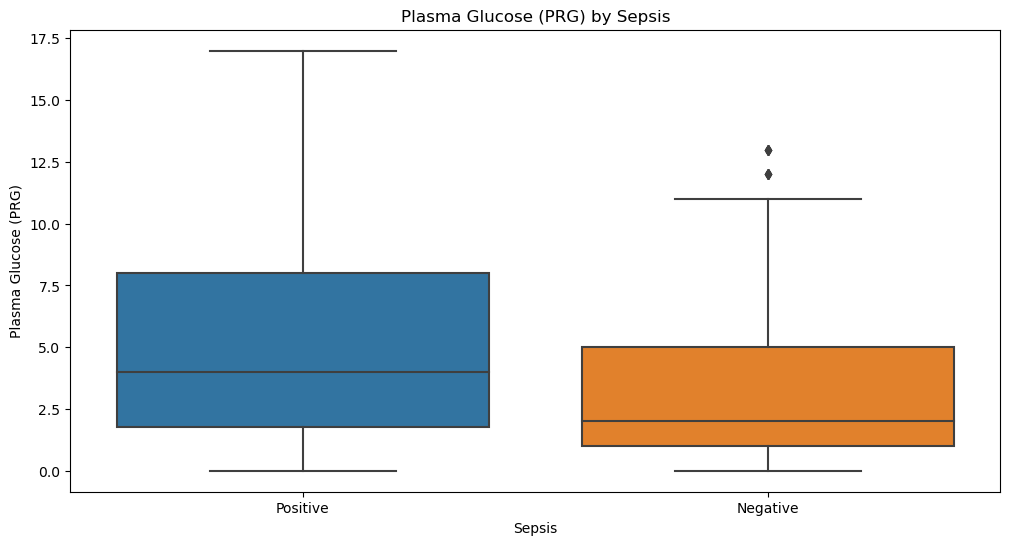

In [15]:
# Box plots for numerical variables by 'Sepsis'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sepssis', y='PRG', data=df_train)
plt.title('Plasma Glucose (PRG) by Sepsis')
plt.xlabel('Sepsis')
plt.ylabel('Plasma Glucose (PRG)')
plt.show()

It will help you assess if there are significant differences in 'Plasma Glucose' levels between patients who develop sepsis and those who do not.
Outliers and variations in the distribution can provide insights into potential risk factors.

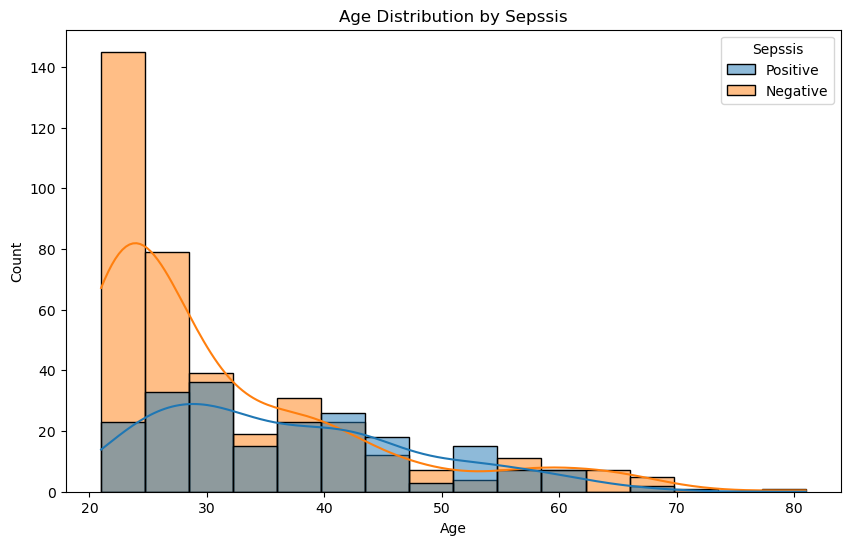

In [16]:
# Histograms for age distribution by 'Sepsis'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Sepssis', kde=True)
plt.title('Age Distribution by Sepssis')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

This visualization will help you understand how age is distributed among patients with and without sepsis.
It can reveal if there are age-related trends or patterns in sepsis cases.

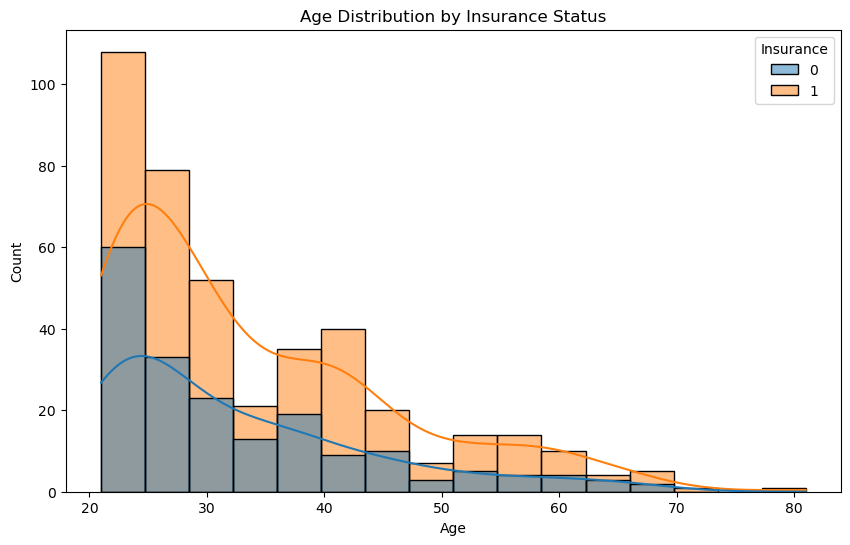

In [17]:
# Example for age distribution by 'Insurance'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Insurance', kde=True)
plt.title('Age Distribution by Insurance Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [18]:
# Define age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'AgeGroup' based on age bins
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=age_bins, labels=age_labels)

# Print the age distribution by 'Insurance' and 'AgeGroup'
age_group_by_insurance = df_train.groupby(['Insurance', 'AgeGroup']).size().unstack().fillna(0)
print("Age Distribution by Insurance Status and Age Group:")
print(age_group_by_insurance)


Age Distribution by Insurance Status and Age Group:
AgeGroup   0-19  20-29  30-39  40-49  50-59  60-69  70-79  80-89  90+
Insurance                                                            
0             0    106     43     21     12      6      0      0    0
1             0    217     85     60     33     14      1      1    0


The age distribution of patients in two categories: those with insurance (1) and those without insurance (0).
Age groups are divided into several categories, such as 0-19, 20-29, 30-39, and so on.

nterpretation:

In the "Insurance 0" row, you can see the count of uninsured patients in each age group. For example, there are 106 uninsured patients in the age group 20-29.
In the "Insurance 1" row, you can see the count of insured patients in each age group. For instance, there are 217 insured patients in the age group 20-29.
Key Insights:

This table allows us to observe the distribution of patients across different age groups for both insured and uninsured individuals.
It highlights that more patients in the 20-29 age group have insurance compared to other age groups.
Conversely, in the uninsured category, there are fewer patients in the older age groups (70-79, 80-89, 90+) compared to the insured group.

In [19]:
# Target Variable distribution by percentage
100*df_train['Sepssis'].value_counts()/len(df_train['Sepssis'])

Negative    65.275459
Positive    34.724541
Name: Sepssis, dtype: float64

In [20]:
df_train['Sepssis'].value_counts()

Negative    391
Positive    208
Name: Sepssis, dtype: int64

* Data is highly imbalanced, ratio=65:35

In [21]:
# Create a NumPy array to represent the target variable
target = np.where(df_train['Sepssis'] == 'Positive', 1, 0)

# Assign the new NumPy array to the 'Churn' column
df_train['Sepssis'] = target

# Verify the conversion
df_train['Sepssis'].unique 

<bound method Series.unique of 0      1
1      0
2      1
3      0
4      1
      ..
594    0
595    1
596    0
597    0
598    1
Name: Sepssis, Length: 599, dtype: int32>

In [22]:
df_train.head(10)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,AgeGroup
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,1,40-49
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,0,30-39
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,1,30-39
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,0,20-29
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,1,30-39
5,ICU200015,5,116,74,0,0,25.6,0.201,30,1,0,20-29
6,ICU200016,3,78,50,32,88,31.0,0.248,26,0,1,20-29
7,ICU200017,10,115,0,0,0,35.3,0.134,29,1,0,20-29
8,ICU200018,2,197,70,45,543,30.5,0.158,53,1,1,50-59
9,ICU200019,8,125,96,0,0,0.0,0.232,54,1,1,50-59


## HYPOTHESIS

In [24]:
import scipy.stats as stats

# Hypothesis 5: Age Distribution by Insurance Status
insured_age = df_train[df_train['Insurance'] == 1]['Age']
uninsured_age = df_train[df_train['Insurance'] == 0]['Age']
t_stat, p_value = stats.ttest_ind(insured_age, uninsured_age, equal_var=False)

# Set the significance level
alpha = 0.05

print("\nHypothesis 5 - Age Distribution by Insurance Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


if p_value < alpha:
    print("Hypothesis 5: There is a significant difference in age distribution between insured and uninsured patients.")
else:
    print("Hypothesis 5: There is no significant difference in age distribution between insured and uninsured patients.")


Hypothesis 5 - Age Distribution by Insurance Status:
T-statistic: 1.359114005409477
P-value: 0.17491186636473033
Hypothesis 5: There is no significant difference in age distribution between insured and uninsured patients.


In [26]:
# Hypothesis 1: Plasma Glucose Levels by Sepsis Status
sepsis_group = df_train[df_train['Sepssis'] == 1]['PRG']
non_sepsis_group = df_train[df_train['Sepssis'] == 0]['PRG']
t_stat, p_value = stats.ttest_ind(sepsis_group, non_sepsis_group, equal_var=False)

# Set the significance level
alpha = 0.05

print("Hypothesis 1 - Plasma Glucose Levels by Sepsis Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Hypothesis 1: There is a significant difference in plasma glucose levels between patients with and without sepsis.")
else:
    print("Hypothesis 1: There is no significant difference in plasma glucose levels between patients with and without sepsis.")


Hypothesis 1 - Plasma Glucose Levels by Sepsis Status:
T-statistic: 4.842533902324343
P-value: 1.924247139438273e-06
Hypothesis 1: There is a significant difference in plasma glucose levels between patients with and without sepsis.


In [28]:
# Hypothesis 2: Blood Pressure by Insurance Status
insured_group = df_train[df_train['Insurance'] == 1]['PR']
uninsured_group = df_train[df_train['Insurance'] == 0]['PR']
t_stat, p_value = stats.ttest_ind(insured_group, uninsured_group, equal_var=False)
print("\nHypothesis 2 - Blood Pressure by Insurance Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


# Set the significance level
alpha = 0.05

if p_value < alpha:
    print("Hypothesis 2: There is a significant difference in blood pressure between insured and uninsured patients.")
else:
    print("Hypothesis 2: There is no significant difference in blood pressure between insured and uninsured patients.")



Hypothesis 2 - Blood Pressure by Insurance Status:
T-statistic: -0.6140188592745929
P-value: 0.539596953434826
Hypothesis 2: There is no significant difference in blood pressure between insured and uninsured patients.


In [31]:
# Hypothesis 3: Age Distribution by Sepsis Status (Kolmogorov-Smirnov test)
sepsis_age = df_train[df_train['Sepssis'] == 1]['Age']
non_sepsis_age = df_train[df_train['Sepssis'] == 0]['Age']
ks_stat, p_value = stats.ks_2samp(sepsis_age, non_sepsis_age)
print("\nHypothesis 3 - Age Distribution by Sepsis Status:")
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

if p_value < alpha:
    print("Hypothesis 3: The age distribution differs significantly between patients with and without sepsis.")
else:
    print("Hypothesis 3: There is no significant difference in age distribution between patients with and without sepsis.")



Hypothesis 3 - Age Distribution by Sepsis Status:
KS Statistic: 0.31081546330906945
P-value: 4.148871074130695e-12
Hypothesis 3: The age distribution differs significantly between patients with and without sepsis.


In [35]:
import scipy.stats as stats

# Hypothesis 4: BMI by Insurance Status (Using Mann-Whitney U Test)
insured_bmi = df_train[df_train['Insurance'] == 1]['M11']
uninsured_bmi = df_train[df_train['Insurance'] == 0]['M11']
u_stat, p_value = stats.mannwhitneyu(insured_bmi, uninsured_bmi, alternative='two-sided')
print("\nHypothesis 4 - BMI by Insurance Status (Mann-Whitney U Test):")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

# Hypothesis 4: BMI by Insurance Status
if p_value < alpha:
    print("Hypothesis 4: There is a significant difference in BMI between insured and uninsured patients.")
else:
    print("Hypothesis 4: There is no significant difference in BMI between insured and uninsured patients.")



Hypothesis 4 - BMI by Insurance Status (Mann-Whitney U Test):
U-statistic: 39643.0
P-value: 0.6078793786433843
Hypothesis 4: There is no significant difference in BMI between insured and uninsured patients.
